**Vulnérabilité aux pollutions et caractéristiques sociodémographiques des territoires**


Par Réda Bounechar, Juliette Lesné et Aurélian Moge - 2025

**Introduction**

L'objectif de ce notebook est d'étudier le rapport entre, d'une part, les caractéristiques sociodémographiques des communes d'Ile-de-France (superficie, densité, composition socioprofessionnelle, revenu médian, dotation en infrastructures...) et, d'autre part, l'exposition de leur population à différentes pollutions. Plus exactement, nous étudions les conséquences mesurables de la dégradation de l'environnement local, sur la qualité de l'air principalement ; ces conséquences doivent également être discriminantes localement, c'est-à-dire non uniformément établies sur la région étudiée, raison pour laquelle les données liées à l'évolution des températures n'ont pas été prises en compte, quoique l'exposition différenciée aux conséquences du changement climatique puisse faire l'objet d'un autre travail.

In [ ]:
!pip install openpyxl
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]1/2 [openpyxl]


In [ ]:
import requests
import zipfile
import openpyxl

import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
import contextily

import json
from shapely.geometry import shape

**Partie 1 : Importation des données**

Dans cette partie, nous importons les données dont nous avons besoin. 

En premier lieu, on importe les données tirées de Géorisques qui nous intéressent : fichier des installations industrielles rejetant des polluants ; volume des rejets industriels par établissement (en m3) ; émissions de produits polluant l'eau, l'air et le sol (en kg) ; production de déchets dangereux (en tonnes).

En second lieu, on importe les données des communes : les coordonnées géographiques d'une part, les données sociodémographiques d'autre part. 


*1.1. Données de pollution industrielle*

On importe le fichier des établissements industriels puis celui des rejets associés, avant de les fusionner. Dans un second temps, on construit un fichier agrégé par commune, qui nous donne une liste des communes (réduite à celles qui ont des établissements polluant), le nombre d'établissements polluant dans celle-ci et la somme des rejets de ces derniers. A noter que ces trois catégories sont répétées trois fois pour prendre en compte les rejets isolés, mais aussi ceux raccordés et le total des rejets. 

Ensuite, on importe le fichier des émissions de polluants et celui des productions de déchets dangereux, qu'on regroupe selon l'établissement puis selon la commune afin d'avoir le nombre d'établissements concernés dans chaque commune.

Enfin, on fusionne tout et on trouve un fichier qui compte, pour chaque commune, le nombre d'établissements qui dépasse chaque seuil. 

In [ ]:
### Etablissements industriels

# On télécharge le dossier des installations industrielles rejetant des polluants (2024)
url_industries_polluantes = "https://files.georisques.fr/irep/2023.zip"
response_industries_polluantes = requests.get(url_industries_polluantes)

# On enregistre le dossier localement
with open("Industries_polluantes.xlsx", "wb") as f:
    f.write(response_industries_polluantes.content)

# On importe le fichier répertoriant les établissements polluants (qui est une liste des établissements)
with zipfile.ZipFile("Industries_polluantes.xlsx", "r") as z:
    with z.open("2023/etablissements.csv") as f:
        industries_polluantes = pd.read_csv(f, sep=None, engine='python')

# On renomme la colonne insee dès maintenant (pour harmoniser ensuite)
industries_polluantes = industries_polluantes.rename(columns={"code_insee" : "insee"})

In [115]:
### Rejets (pour chaque établissement listé dans industries_polluantes)

# On import le fichier des rejets
with zipfile.ZipFile("Industries_polluantes.xlsx", "r") as z:
    with z.open("2023/rejets.csv") as f:
        rejets = pd.read_csv(f, sep=None, engine='python')

# On renomme également la colonne insee
rejets = rejets.rename(columns = {"code_insee" : "insee"})

# On fusionne les deux tables
etablissements_rejets = pd.merge(industries_polluantes, rejets, on=["identifiant", "nom_etablissement", "code_postal", "insee",
"commune", "code_departement", "departement", "code_region", "region"], how="inner")

# On regroupe par la commune et on enregistre les pollutions (total des rejets ET nombre d'établissements)
etablissements_rejets_agr = etablissements_rejets.groupby("insee").agg(
    rejets_isoles=("rejet_isole_m3_par_an", "sum"),
    nb_etablissements_isoles=("rejet_isole_m3_par_an", "count"),
    rejets_raccordes=("rejet_raccorde_m3_par_an", "sum"),
    nb_etablissements_raccordes=("rejet_raccorde_m3_par_an", "count")).reset_index()

# On fait, pour chaque commune, la somme des rejets raccordés et isolés pour les deux colonnes concernées
etablissements_rejets_agr["rejets_tot"] = etablissements_rejets_agr["rejets_isoles"] + etablissements_rejets_agr["rejets_raccordes"]
etablissements_rejets_agr["nb_etablissements_rejets_tot"] = etablissements_rejets_agr["nb_etablissements_isoles"] + etablissements_rejets_agr["nb_etablissements_raccordes"]

In [220]:
### Emissions

# On importe le fichier des émissions
with zipfile.ZipFile("Industries_polluantes.xlsx", "r") as z:
    with z.open("2023/emissions.csv") as f:
        emissions = pd.read_csv(f, sep=None, engine='python')

# On renomme la colonne insee
emissions = emissions.rename(columns = {"code_insee" : "insee"})

# On convertit en numériques les quantités d'émission (pour distinguer les nombres des lignes "inférieur au seuil")
emissions["quantite"] = pd.to_numeric(emissions["quantite"], errors="coerce")

# On supprime les lignes où il est écrit "inférieur au seuil" et qui sont devenues NAs
emissions = emissions.dropna(axis=0)

# On regroupe par identifiant d'établissement et on affiche la commune pour conserver l'information
emissions_agr = (
    emissions
    .groupby("identifiant")
    .agg(
        insee=("insee", "first"),
        nombre_emissions=("identifiant", "count")
    )
    .reset_index()
)

# On regroupe ensuite par commune : on compte le nombre d'établissements, puis le nombre d'établissements par "gravité" des émissions
# (une seule dans l'établissement, ou 2, ou 3, ou 4 et plus)
emissions_agr_agr = (
    emissions_agr
    .groupby("insee")
    .agg(
        nombre_etablissements_emissions=("identifiant", "count"),
        nombre_etablissements_emissions_2_plus=("nombre_emissions", lambda x: (x >= 2).sum()),
        nombre_etablissements_emissions_3_plus=("nombre_emissions", lambda x: (x >= 3).sum()),
    )
    .reset_index()
)

In [222]:
### Dechets

# On importe le fichier des déchets dangereux
with zipfile.ZipFile("Industries_polluantes.xlsx", "r") as z:
    with z.open("2023/Prod_dechets_dangereux.csv") as f:
        dechets_dangereux = pd.read_csv(f, sep=None, engine='python')

# Pareil, on renomme la colonne insee, et on supprime les NAs dans les quantités
dechets_dangereux = dechets_dangereux.rename(columns = {"code_insee" : "insee"})
dechets_dangereux["quantite"] = pd.to_numeric(dechets_dangereux["quantite"], errors="coerce")
dechets_dangereux = dechets_dangereux.dropna(axis=0, subset = ["quantite"])

# On fait exactement la même chose pour l'agrégation
dechets_dangereux_agr = (
    dechets_dangereux
    .groupby("identifiant")
    .agg(
        insee=("insee", "first"),
        nombre_dechets=("identifiant", "count")
    )
    .reset_index()
)

dechets_dangereux_agr_agr = (
    dechets_dangereux_agr
    .groupby("insee")
    .agg(
        nombre_etablissements_dechets=("identifiant", "count"),
        nombre_etablissements_dechets_2_plus=("nombre_dechets", lambda x: (x >= 2).sum()),
        nombre_etablissements_dechets_3_plus=("nombre_dechets", lambda x: (x >= 3).sum()),
    )
    .reset_index()
)

In [224]:
### Fusion des quatre jeux de données

georisques = (
    etablissements_rejets_agr
    .merge(emissions_agr_agr, on="insee", how="outer")
    .merge(dechets_dangereux_agr_agr, on="insee", how="outer")
)

*1.2. Données géographiques et sociodémographiques*

In [225]:
#### On importe le fichier avec les shapefiles des communes

# Téléchargement du fichier avec les shapefiles des communes, directement depuis Datagouv
url_communes = "https://www.data.gouv.fr/api/1/datasets/r/0e117c06-248f-45e5-8945-0e79d9136165"
zip_communes = "shapefiles.zip"

# Enregistrement du fichier localement
response_communes = requests.get(url_communes)
with open(zip_communes, "wb") as f:
    f.write(response_communes.content)

# Importation avec GeoPandas
communes = gpd.read_file(f"zip://{zip_communes}!communes-20220101.shp")
communes.head()

,insee,nom,wikipedia,surf_ha,geometry
0,2B222,Pie-d'Orezza,fr:Pie-d'Orezza,573.0,"POLYGON ((9.32017 42.38507, 9.32028 42.3851, 9..."
1,2B137,Lano,fr:Lano,824.0,"POLYGON ((9.2001 42.39013, 9.20014 42.39014, 9..."
2,2B051,Cambia,fr:Cambia,833.0,"POLYGON ((9.27757 42.37509, 9.27758 42.37512, ..."
3,2B106,Érone,fr:Érone,393.0,"POLYGON ((9.2512 42.37605, 9.25132 42.37603, 9..."
4,2B185,Oletta,fr:Oletta,2674.0,"POLYGON ((9.2834 42.66273, 9.28345 42.66273, 9..."


In [226]:
# On duplique les colonnes Paris, Lyon et Marseille pour les arrondissements

communes_ext = communes.copy()

## Pour Paris

# On enregistre la ligne de Paris
communes_paris = communes_ext[communes_ext["insee"] == "75056"]

# On la copie 20 fois
communes_paris_20 = communes_paris.loc[communes_paris.index.repeat(20)].copy()

# On change uniquement la colonne insee (on changera les autres plus tard selon les besoins)
communes_paris_20["insee"] = [f"751{str(i).zfill(2)}" for i in range(1, 21)]    #f" permet d'insérer une variable dans une chaîne, str(i) convertit les chiffres et zfill ajoute des zéros à gauche pour le code insee

# On ajoute nos lignes au df original
i = communes_paris.index[0]         # on récupère la position de la ligne de Paris
communes_ext = pd.concat(                       # on assemble deux df aux colonnes identiques via pd.concat
    [communes_ext.iloc[:i+1], communes_paris_20, communes_ext.iloc[i+1:]],       # toutes nos lignes jusqu'à Paris - puis Paris - puis tout le reste 
    ignore_index=True
)

## Idem pour Lyon
communes_lyon = communes_ext[communes_ext["insee"] == "69123"]
communes_lyon_20 = communes_lyon.loc[communes_lyon.index.repeat(9)].copy()
communes_lyon_20["insee"] = [f"6938{str(i)}" for i in range(1, 10)]

j = communes_lyon.index[0]
communes_ext = pd.concat(
    [communes_ext.iloc[:j+1], communes_lyon_20, communes_ext.iloc[j+1:]],
    ignore_index=True
)

## Et pour Marseille
communes_marseille = communes_ext[communes_ext["insee"] == "13055"]
communes_marseille_20 = communes_marseille.loc[communes_marseille.index.repeat(16)].copy()
communes_marseille_20["insee"] = [f"132{str(i).zfill(2)}" for i in range(1, 17)]

k = communes_marseille.index[0]
communes_ext = pd.concat(
    [communes_ext.iloc[:k+1], communes_marseille_20, communes_ext.iloc[k+1:]],
    ignore_index=True
)

In [227]:
### On fait une première fusion entre les communes et les pollutions industrielles

# On fait la jointure (en ne conservant que les communes qui sont dans les deux df, ie celles qui ont des rejets identifiés)
communes_rejets = pd.merge(communes_ext, georisques, on="insee", how = "inner")

# Conversion du fichier au format GeoPandas
communes_rejets = gpd.GeoDataFrame(communes_rejets, geometry='geometry')

# On crée un df avec les communes et une variable polluée ou non (binaire)
communes_statut = communes_ext.copy()
communes_statut["Polluee"] = communes_statut["insee"].isin(communes_rejets["insee"])

# On regarde combien on en a (4 752 polluées parmi 35 000 : environ 13-14%)
print(communes_statut["Polluee"].sum(), communes_ext.shape)

4752 (35000, 5)


In [228]:
# Avant de fusionner etablissements_rejets et communes_statut, on vérifie qu'il n'y a pas d'incohérence
print(
    (set(etablissements_rejets["insee"].astype(str)) - set(communes_statut["insee"].astype(str))),
    (set(communes_statut["insee"].astype(str)) - set(etablissements_rejets["insee"].astype(str)))
    )

# On supprime les codes en trop
codes_pollution = set(etablissements_rejets["insee"].astype(str))
codes_communes  = set(communes_statut["insee"].astype(str))
codes_non_trouves = codes_pollution - codes_communes
codes_arrondissements = {c for c in codes_non_trouves if c.startswith(("75", "13", "69"))}
etablissements_rejets = etablissements_rejets[
    ~etablissements_rejets["insee"].astype(str).isin(codes_non_trouves - codes_arrondissements)
]

set() {'10024', '78403', '23210', '02690', '14453', '2B188', '42157', '47318', '02305', '24496', '51149', '62587', '40153', '89472', '95594', '30244', '31392', '77080', '65231', '70482', '16114', '72191', '25452', '25012', '25284', '72112', '39103', '34196', '18001', '51292', '02165', '33005', '83094', '65063', '22242', '89369', '49009', '72004', '60566', '55021', '80502', '01423', '61062', '35015', '02013', '38239', '25574', '89397', '60055', '76076', '60066', '11428', '70265', '51179', '80550', '10252', '02007', '50277', '89332', '68016', '80750', '81060', '56181', '97202', '63091', '10383', '50150', '09244', '02350', '65369', '50022', '52534', '74108', '24438', '39461', '84109', '24383', '40233', '01336', '39235', '70117', '24087', '39328', '42117', '02334', '55352', '72259', '18022', '60447', '2B175', '57535', '65429', '77126', '55160', '51605', '68275', '05090', '64546', '18096', '40019', '94079', '14143', '10280', '39359', '26336', '39038', '16249', '39284', '51308', '29163', '76

In [ ]:
# On fusionne pour Paris, Lyon et Marseille (dans une colonne à part au cas où)
#etablissements_rejets["insee_agr"] = etablissements_rejets["insee"]
#etablissements_rejets["insee_agr"] = etablissements_rejets["insee_agr"].replace(["13203", "13205", "13208", "13209", "13210", "13211", "13214", "13215", "13216"],
#"13055").astype(str)
#etablissements_rejets["insee_agr"] = etablissements_rejets["insee_agr"].replace(["69383", "69384", "69387", "69388", "69389"],"69123").astype(str)
#etablissements_rejets["insee_agr"] = etablissements_rejets["insee_agr"].replace(["75101", "75109", "75111", "75112", "75115"],"75056").astype(str)

In [229]:
# On fusionne georisques et communes_statut (ce qui étend communes_statut avec, au-delà du statut, des précisions sur les pollutions)
communes_statut = pd.merge(communes_statut, georisques, on = "insee", how = "left")

In [132]:
#### On importe le dossier complet de l'INSEE pour apparier avec des données "sociales"

# On télécharge le dossier qui contient notre csv
url_complet = "https://www.insee.fr/fr/statistiques/fichier/5359146/dossier_complet.zip"
zip_path = "dossier_complet.zip" 

# On enregistre le fichier localement
response = requests.get(url_complet)
with open(zip_path, "wb") as f:
    f.write(response.content)

# On importe notre fichier avec Pandas (et on l'appelle complet_insee)
csv_complet_insee = "dossier_complet.csv" 
with zipfile.ZipFile(zip_path) as z:
    with z.open(csv_complet_insee) as f:
        complet_insee = pd.read_csv(f, sep=';', encoding='utf-8')

/tmp/ipykernel_11397/1042689086.py:16: DtypeWarning: Columns (0,1701,1702) have mixed types. Specify dtype option on import or set low_memory=False.
  complet_insee = pd.read_csv(f, sep=';', encoding='utf-8')


In [230]:
# On renomme la colonne CODGEO en insee (comme tous les autres df)
complet_insee = complet_insee.rename(columns={"CODGEO" : "insee"})

# Puis on la convertit en chaine de caractères
complet_insee["insee"] = complet_insee["insee"].astype(str).str.zfill(5)

In [231]:
#### On fait à nouveau la jointure avec notre df précédent

# On s'assure que la variable "insee" est similaire dans les deux tableaux
communes_statut['insee'] = communes_statut['insee'].astype(str).str.zfill(5)    # zfill remplit de zéros à gauche pour atteindre 5 signes (pour harmoniser à la norme INSEE)
complet_insee['insee'] = complet_insee['insee'].astype(str).str.zfill(5)

# On fusionne
communes_complet = pd.merge(communes_statut, complet_insee, on="insee") # on obtient un tableau à 1997 colonnes (et 34 976 lignes)
communes_complet.shape

(34976, 1993)

In [ ]:
##############################################
####### PARTIE 2 : RECODAGE POUR L'IDF #######
##############################################

In [232]:
### On se concentre sur l'idf

# On crée un df communes seulement avec l'idf
communes_complet["departement"] = communes_complet["insee"].astype(str).str.slice(0,2)
communes_idf = communes_complet.copy()
communes_idf = communes_idf[communes_idf["departement"].isin(["75", "77", "78", "91", "92", "93", "94", "95"])]

In [233]:
## On importe la pollution de l'air

# On ouvre le df avec la pollution de l'air
url_pollution_air = "https://www.data.gouv.fr/api/1/datasets/r/da7a4869-b584-48ad-8a81-784a02eb297a"
pollution_air = pd.read_csv(url_pollution_air) 
pollution_air.shape

# On se restreint aux mesures de 2018 (les plus récentes)
pollution_air_2018 = pollution_air[pollution_air['date'] == '01/04/2018'].copy()

# S'assurer que la colonne est bien au format string
pollution_air_2018['ninsee'] = pollution_air_2018['ninsee'].astype(str)

# Garder seulement les codes INSEE de 5 chiffres ou plus
pollution_air_2018 = pollution_air_2018[pollution_air_2018['ninsee'].str.len() >= 5]

# On renomme la variable CODGEO en "insee" pour que ce soit homogène
pollution_air_2018 = pollution_air_2018.rename(columns={"ninsee":"insee"})

In [234]:
#### Avant de faire la jointure, on regarde si des lignes diffèrent entre pollution_air_2018 et communes_idf

# On regarde la taille des deux df
print(communes_idf.shape, pollution_air_2018.shape) # il y a 13 lignes de plus dans pollution_air_2018

# On regarde quelles lignes manquent

# Dans ce sens, ce sont des communes qui ont disparues depuis 2018
set(pollution_air_2018["insee"].astype(str)) - set(communes_idf["insee"].astype(str))

# Dans l'autre sens, il n'y a que Paris (qui n'existe pas dans pollution_air_2018 car ce sont des arrondissements) - on accepte de la perdre !

(1287, 1994) (1300, 5)


{'77028',
 '77149',
 '77166',
 '77170',
 '77299',
 '77399',
 '77491',
 '78251',
 '78503',
 '78524',
 '91182',
 '91222',
 '95259',
 '95282'}

In [235]:
#### On fait la jointure avec notre df sur la pollution de l'air (qui ne concerne que l'idf)

# On s'assure que la variable "insee" est similaire dans les deux tableaux
communes_idf['insee'] = communes_idf['insee'].astype(str).str.zfill(5)  # zfill remplit de zéros à gauche pour atteindre 5 signes (pour harmoniser à la norme INSEE)
pollution_air_2018['insee'] = pollution_air_2018['insee'].astype(str).str.zfill(5)

# On fusionne
communes_idf = pd.merge(communes_idf, pollution_air_2018, on="insee") 
communes_idf.shape

(1286, 1998)

In [238]:
### On importe les bonnes géométries pour les arrondissements parisiens

# Téléchargement du fichier avec les shapefiles des communes, directement depuis le site de la ville de Paris
url_arrondissements = "https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/arrondissements/exports/csv?lang=fr&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B"
csv_arrondissements = "arrondissements.csv"

# Enregistrement du fichier localement
response_arrondissements = requests.get(url_arrondissements)
with open(csv_arrondissements, "wb") as f:
    f.write(response_arrondissements.content)

# Importation avec GeoPandas
arrondissements = gpd.read_file(csv_arrondissements)

# On ne garde que les colonnes qui nous intéressent, on les renomme et on convertit la surface (de m2 à ha)
arrondissements = arrondissements.iloc[:, [2, 6, 9]]
arrondissements.columns = ["insee", "surf_ha", "geometry"]
arrondissements["surf_ha"] = arrondissements["surf_ha"].astype(float) / 10_000

In [239]:
### On fusionne nos arrondissements avec notre fichier des communes (pour mettre à jour la géométrie - le reste est déjà correct)

# On convertit la colonne geometry en Shapely (elle était en JSON nativement)
arrondissements["geometry"] = arrondissements["geometry"].apply(lambda x: shape(json.loads(x)))
arrondissements["geometry"] = arrondissements["geometry"].apply(shape)

# On ajoute nos arrondissements
for col in ["surf_ha", "geometry"]:
    # On crée un dictionnaire qui, à chaque code insee, assigne la nouvelle valeur de la colonne
    update_dict = dict(zip(arrondissements["insee"], arrondissements[col]))
    
    # On remplace dans communes_idf_short
    communes_idf[col] = communes_idf["insee"].map(update_dict).combine_first(communes_idf[col])

# On s'assure qu'on a toujours un gdf
communes_idf = gpd.GeoDataFrame(
    communes_idf,
    geometry='geometry', 
    crs="EPSG:2154"
)

In [240]:
#### On ajoute la variable du centroid au df (pour faire des calculs simples éventuellement)
communes_idf['centroid'] = communes_idf.geometry.centroid 
communes_idf['x'] = communes_idf.centroid.x # coordonnées est-ouest (longitude)
communes_idf['y'] = communes_idf.centroid.y # nord-sud (latitude)

In [241]:
## Quelques variables à créer

# On crée une variable "densité"
communes_idf["densite"] = communes_idf["P22_POP"] / communes_idf["surf_ha"]

# Une variable pour la part de chaque CS
communes_idf["part_ouvriers"] = communes_idf["C22_POP15P_STAT_GSEC16_26"] / communes_idf["P22_POP"]
communes_idf["part_cpis"] = communes_idf["C22_POP15P_STAT_GSEC13_23"] / communes_idf["P22_POP"]
communes_idf["part_agriculteurs"] = communes_idf["C22_POP15P_STAT_GSEC11_21"] / communes_idf["P22_POP"]
communes_idf["part_employes"] = communes_idf["C22_POP15P_STAT_GSEC15_25"] / communes_idf["P22_POP"]
communes_idf["part_pi"] = communes_idf["C22_POP15P_STAT_GSEC14_24"] / communes_idf["P22_POP"]
communes_idf["part_artisans"] = communes_idf["C22_POP15P_STAT_GSEC12_22"] / communes_idf["P22_POP"]

/tmp/ipykernel_11397/1304762739.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  communes_idf_dem["TP6021"] = pd.to_numeric(communes_idf_dem["TP6021"], errors='coerce') # la méthode coerce convertit automatiquement en NAs les caractères
/tmp/ipykernel_11397/1304762739.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  communes_idf_dem["RD21"] = pd.to_numeric(communes_idf_dem["RD21"], errors='coerce')
/tmp/ipykernel_11397/1304762739.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy o

<Axes: >

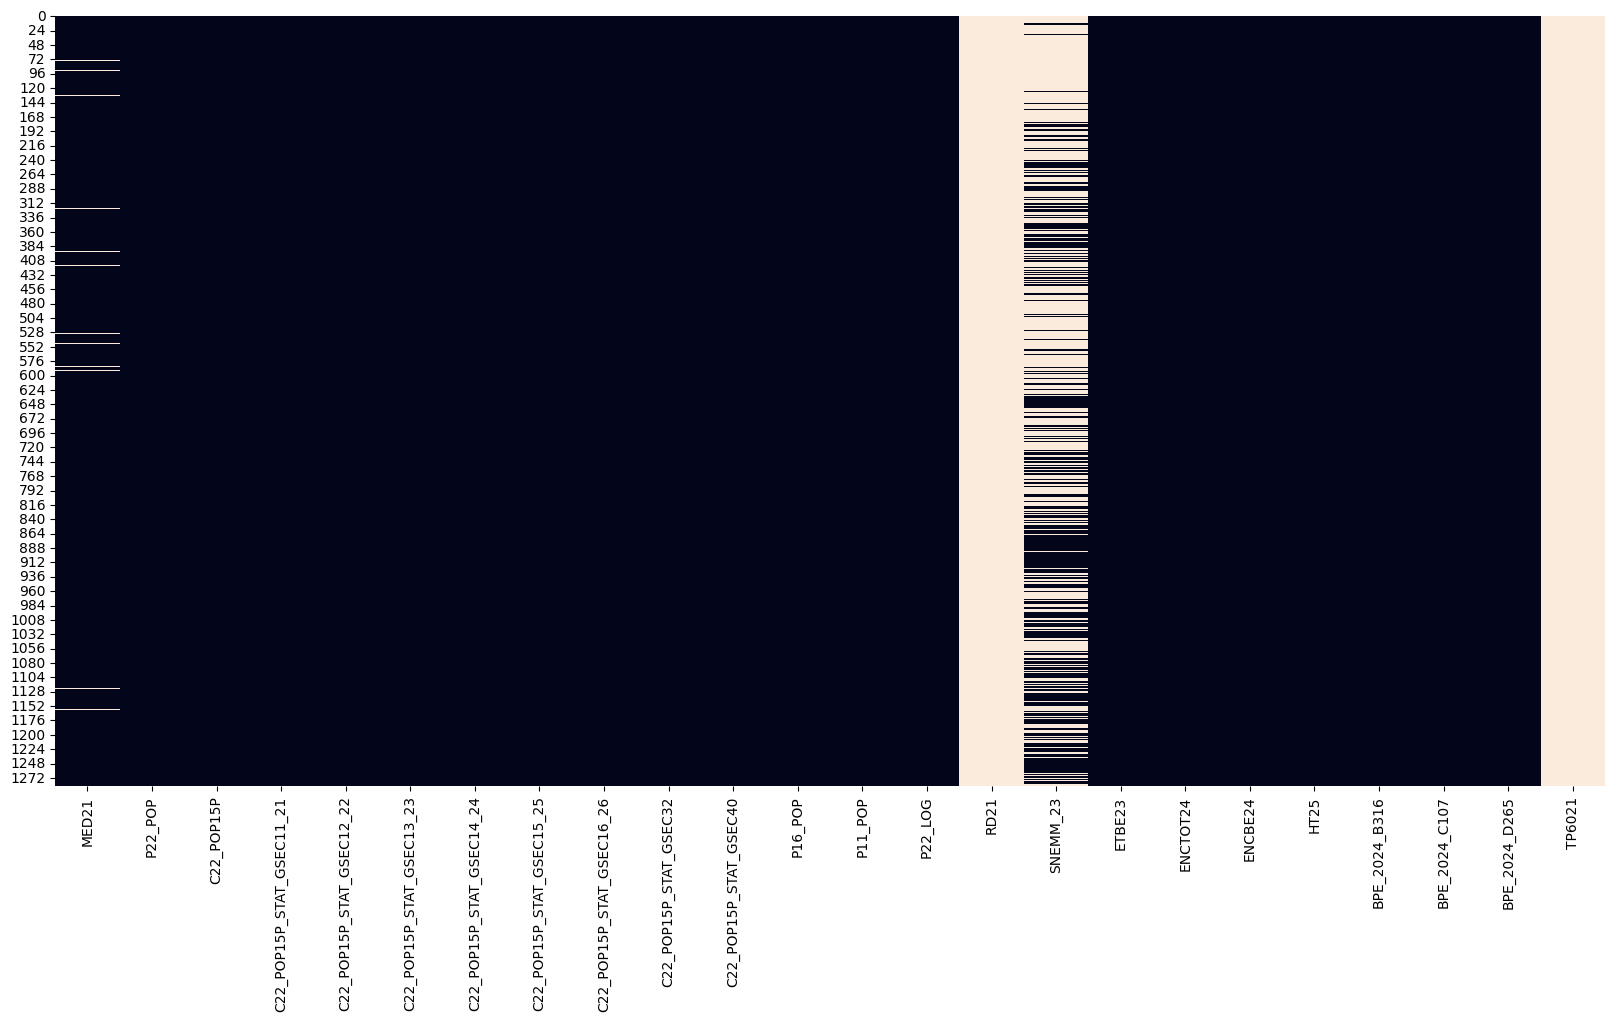

In [242]:
#### On cherche maintenant à trier dans nos variables d'intérêt : on regarde nos variables démographiques et on visualise les NAs

# On crée un df avec les variables démographiques d'intérêt
communes_idf_dem = communes_idf[["MED21", "P22_POP", "C22_POP15P", "C22_POP15P_STAT_GSEC11_21", "C22_POP15P_STAT_GSEC12_22", "C22_POP15P_STAT_GSEC13_23",
"C22_POP15P_STAT_GSEC14_24", "C22_POP15P_STAT_GSEC15_25", "C22_POP15P_STAT_GSEC16_26", "C22_POP15P_STAT_GSEC32", "C22_POP15P_STAT_GSEC40",
"P16_POP", "P11_POP", "P22_LOG", "RD21", "SNEMM_23", "ETBE23", "ENCTOT24", "ENCBE24", "HT25", "BPE_2024_B316", "BPE_2024_C107", "BPE_2024_D265", "TP6021"]]

# On transforme les "s" (convention INSEE) en NAs (ce qu'ils signifient) - cela ne concerne que TP6021 et RD21 (les autres sont déjà des float)
communes_idf_dem["TP6021"] = pd.to_numeric(communes_idf_dem["TP6021"], errors='coerce') # la méthode coerce convertit automatiquement en NAs les caractères
communes_idf_dem["RD21"] = pd.to_numeric(communes_idf_dem["RD21"], errors='coerce')
communes_idf_dem["MED21"] = pd.to_numeric(communes_idf_dem["MED21"], errors='coerce')

# On visualise les NAs
plt.figure(figsize=(20,10))
sns.heatmap(communes_idf_dem.isna(), cbar=False)

In [243]:
# On regarde les NAs
communes_idf_dem.isna().sum()

MED21                          15
P22_POP                         1
C22_POP15P                      1
C22_POP15P_STAT_GSEC11_21       1
C22_POP15P_STAT_GSEC12_22       1
C22_POP15P_STAT_GSEC13_23       1
C22_POP15P_STAT_GSEC14_24       1
C22_POP15P_STAT_GSEC15_25       1
C22_POP15P_STAT_GSEC16_26       1
C22_POP15P_STAT_GSEC32          1
C22_POP15P_STAT_GSEC40          1
P16_POP                         1
P11_POP                         1
P22_LOG                         1
RD21                         1286
SNEMM_23                      740
ETBE23                          1
ENCTOT24                        1
ENCBE24                         1
HT25                            1
BPE_2024_B316                   1
BPE_2024_C107                   1
BPE_2024_D265                   1
TP6021                       1286
dtype: int64

In [245]:
#### On réduit, à titre provisoire, notre df total à quelques variables d'intérêt (sans TP601, RD21 ni SNEMM_23 à cause des NAs)

# On sélectionne les variables
communes_idf_short = communes_idf.copy()
communes_idf_short = communes_idf_short[[
    
    # Variables descriptives
"insee", "nom", "departement", "densite", "surf_ha", "geometry", "centroid", "x", "y",

    # Variables démographiques (dossier complet de l'insee)
"MED21", "P22_POP", "C22_POP15P", "C22_POP15P_STAT_GSEC11_21", "C22_POP15P_STAT_GSEC12_22", "C22_POP15P_STAT_GSEC13_23",
"C22_POP15P_STAT_GSEC14_24", "C22_POP15P_STAT_GSEC15_25", "C22_POP15P_STAT_GSEC16_26", "C22_POP15P_STAT_GSEC32", "C22_POP15P_STAT_GSEC40",
"P16_POP", "P11_POP", "P22_LOG", "ETBE23", "ENCTOT24", "ENCBE24", "HT25", "BPE_2024_B316", "BPE_2024_C107", "BPE_2024_D265",
"part_agriculteurs", "part_artisans", "part_cpis", "part_pi", "part_employes", "part_ouvriers",

    # Variables liées à la pollution industrielles tirées de Géorisques
"Polluee", "rejets_isoles", "nb_etablissements_isoles", "rejets_raccordes", "nb_etablissements_raccordes", "rejets_tot", "nb_etablissements_rejets_tot",
"nombre_etablissements_emissions", "nombre_etablissements_emissions_2_plus", "nombre_etablissements_dechets", "nombre_etablissements_dechets_2_plus",
"nombre_etablissements_dechets_3_plus",

    # Variables liées à la pollution de l'air
"no2", "o3", "pm10"]]

In [246]:
# On renomme les colonnes 

communes_idf_short = communes_idf_short.rename(
    columns = {"MED21" : "revenu_median_2021",
    "P22_POP" : "population_2022",
    "C22_POP15P" : "population_15_plus",
    "C22_POP15P_STAT_GSEC11_21" : "nombre_agriculteurs",
    "C22_POP15P_STAT_GSEC12_22" : "nombre_artisans",
    "C22_POP15P_STAT_GSEC13_23" : "nombre_cpis",
    "C22_POP15P_STAT_GSEC14_24" : "nombre_pi",
    "C22_POP15P_STAT_GSEC15_25" : "nombre_employes",
    "C22_POP15P_STAT_GSEC16_26" : "nombre_ouvriers",
    "C22_POP15P_STAT_GSEC32" : "nombre_retraites",
    "C22_POP15P_STAT_GSEC40" : "nombre_sans_activite",
    "P16_POP" : "population_2016",
    "P11_POP" : "population_2011",
    "P22_LOG" : "nombre_logements",
    "ETBE23" : "nombre_etablissements_industrie",
    "ENCTOT24" : "creations_entreprises",
    "ENCBE24" : "creations_entreprises_industrie",
    "HT25" : "nombre_hôtels_2025",
    "BPE_2024_B316" : "nombre_stations_service",
    "BPE_2024_C107" : "nombre_ecoles_maternelles",
    "BPE_2024_D265" : "nombre_medecins_generalistes"
    }
)

In [247]:
## Nettoyage

# On convertit le revenu médian en numérique
communes_idf_short["revenu_median_2021"] = pd.to_numeric(communes_idf_short["revenu_median_2021"], errors = "coerce")

# On nettoie le revenu médian en supprimant les (15) lignes non renseignées
communes_idf_short = communes_idf_short.dropna(subset=['revenu_median_2021'])

# On supprime la ville de Pierrefitte (dont on a remarqué qu'elle est la seule pour laquelle P22_POP n'est pas renseignée)
communes_idf_short = communes_idf_short[communes_idf_short["insee"] != "93059"]

<Axes: >

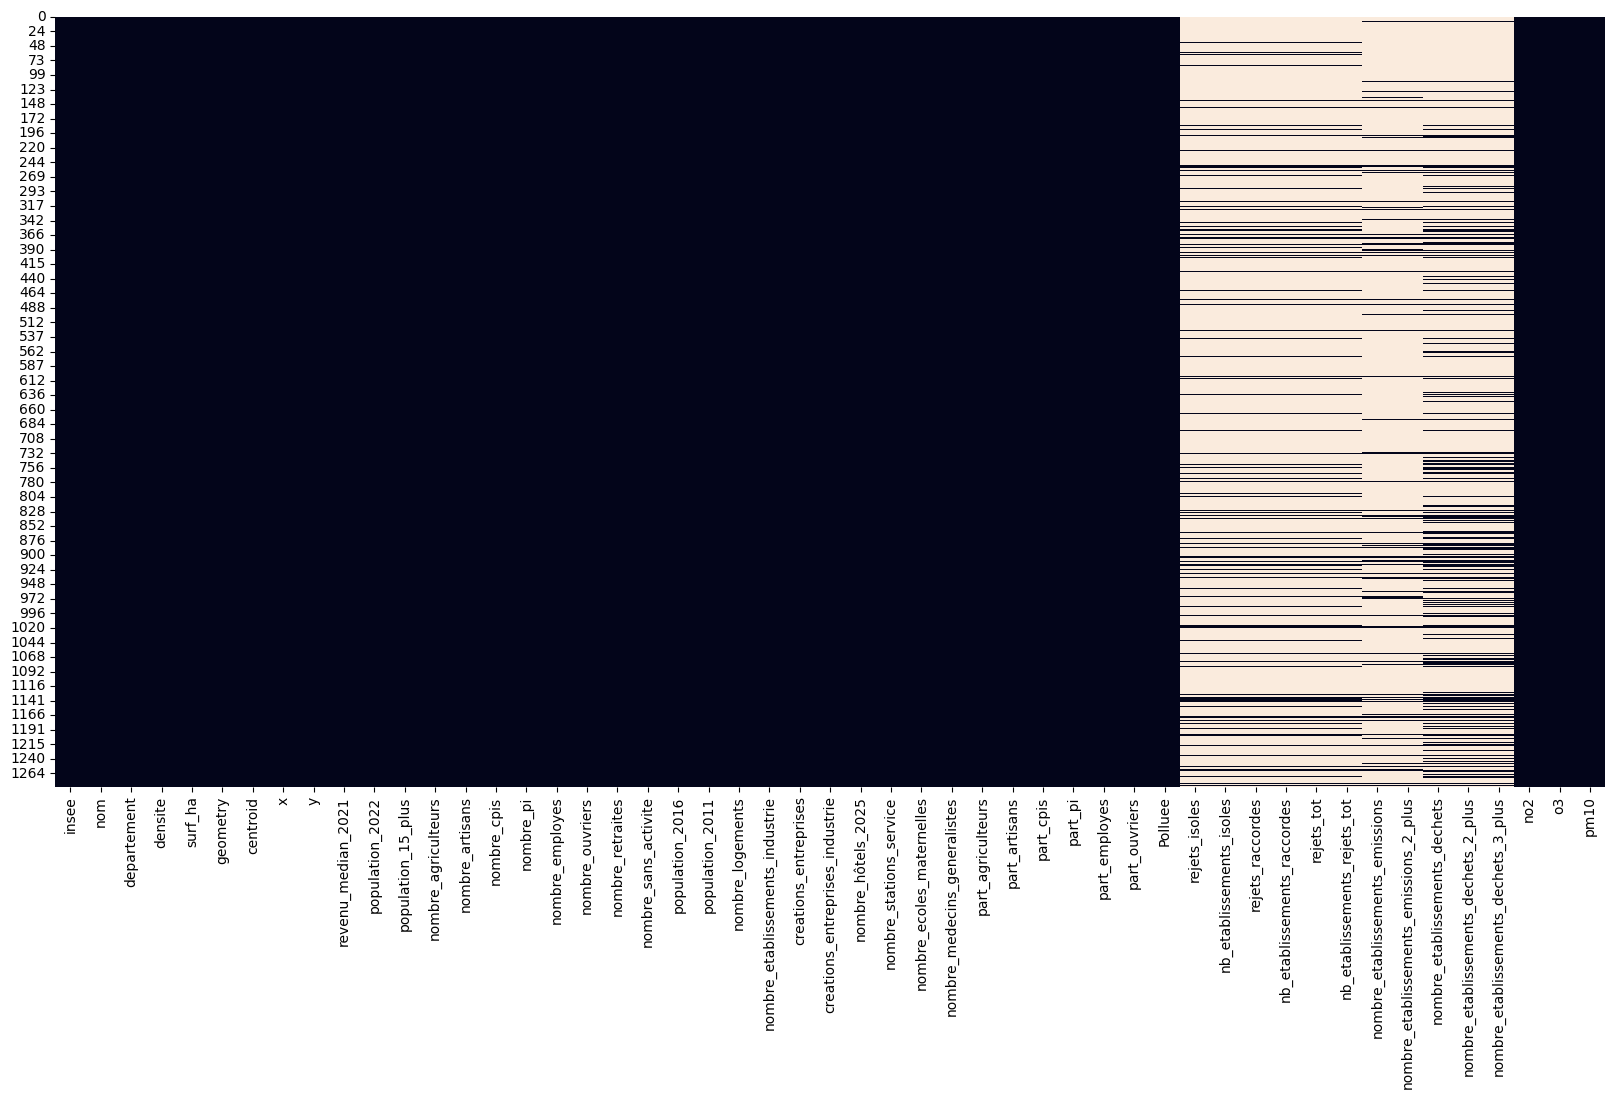

In [248]:
# On visualise les valeurs manquantes (aucune sauf pour les rejets - car NA = 0 ici)
plt.figure(figsize=(20,10))
sns.heatmap(communes_idf_short.isna(), cbar=False)

**Partie 3 : Visualisations et analyses exploratoires**

(np.float64(1.3405956849999998),
 np.float64(3.6648696149999997),
 np.float64(48.06408132992269),
 np.float64(49.297495269618935))

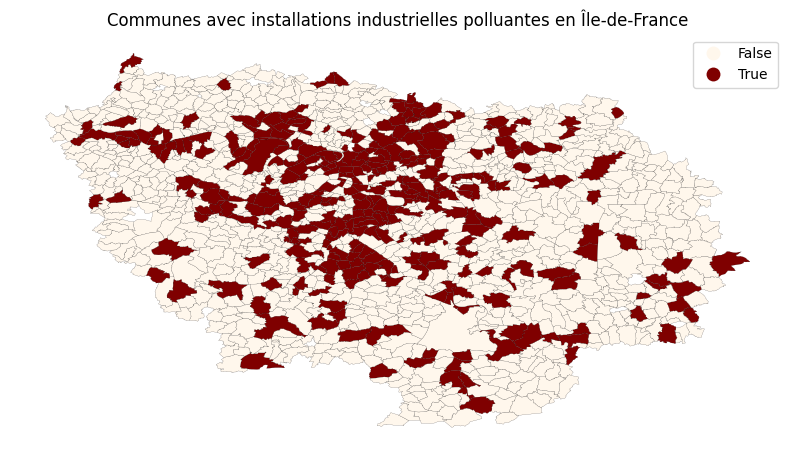

In [252]:
# Communes polluées (au sens large) par des installations industrielles

fig, ax = plt.subplots(figsize=(10, 10))
communes_idf_short.plot(
    column="Polluee",
    legend=True,
    cmap="OrRd",  # rouge / orange
    ax=ax,
    edgecolor="black",
    linewidth=0.1
)
ax.set_title("Communes avec installations industrielles polluantes en Île-de-France")
ax.axis("off")

(np.float64(1.3405956849999998),
 np.float64(3.6648696149999997),
 np.float64(48.06408132992269),
 np.float64(49.297495269618935))

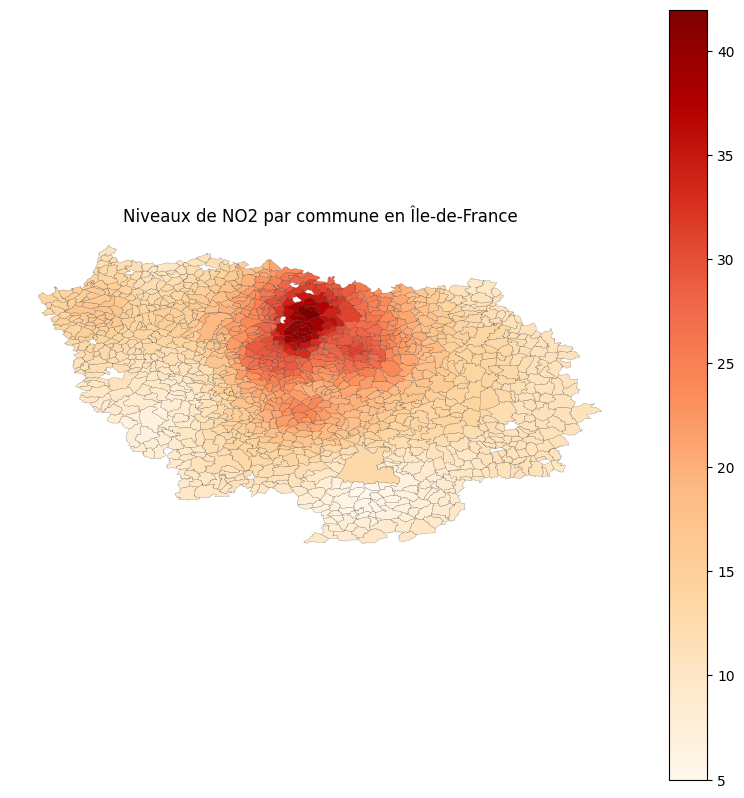

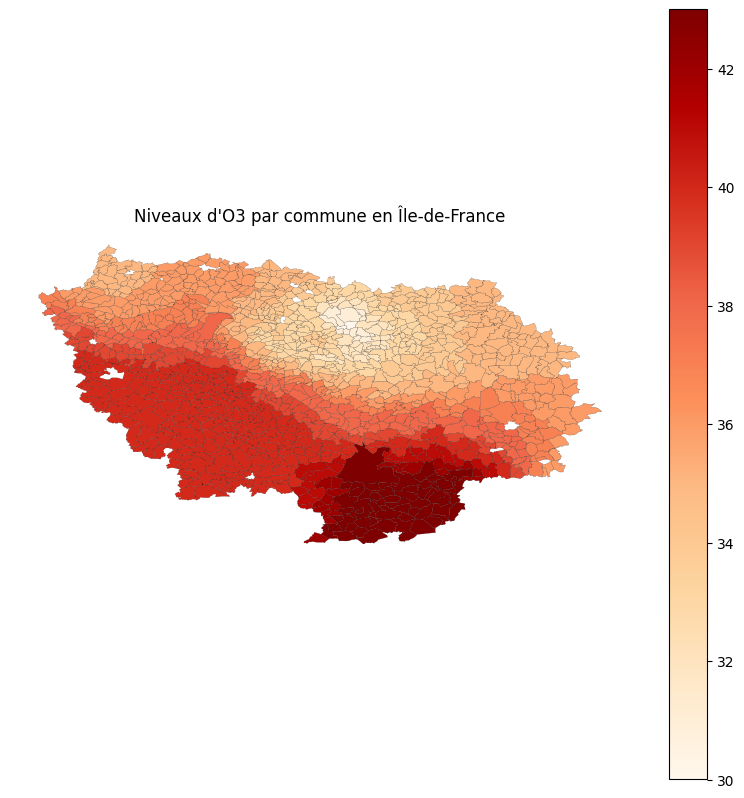

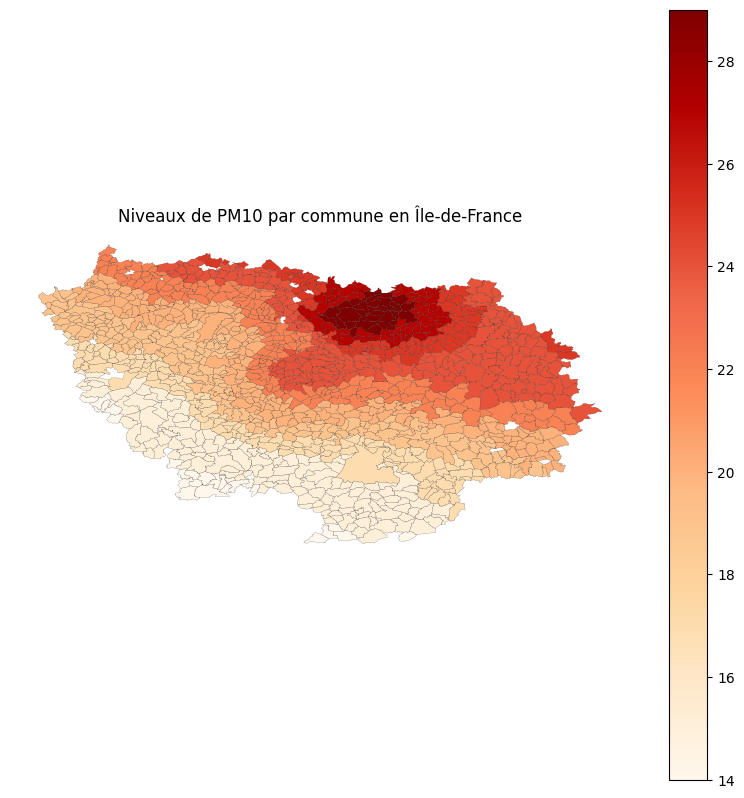

In [253]:
# NO2
fig, ax = plt.subplots(figsize=(10, 10))
communes_idf_short.plot(
    column="no2",
    legend=True,
    cmap="OrRd",  # rouge / orange
    ax=ax,
    edgecolor="black",
    linewidth=0.1
)
ax.set_title("Niveaux de NO2 par commune en Île-de-France")
ax.axis("off")

# 03
fig, ax = plt.subplots(figsize=(10, 10))
communes_idf_short.plot(
    column="o3",
    legend=True,
    cmap="OrRd",  # rouge / orange
    ax=ax,
    edgecolor="black",
    linewidth=0.1
)
ax.set_title("Niveaux d'O3 par commune en Île-de-France")
ax.axis("off")

# PM10
fig, ax = plt.subplots(figsize=(10, 10))
communes_idf_short.plot(
    column="pm10",
    legend=True,
    cmap="OrRd",  # rouge / orange
    ax=ax,
    edgecolor="black",
    linewidth=0.1
)

ax.set_title("Niveaux de PM10 par commune en Île-de-France")
ax.axis("off")

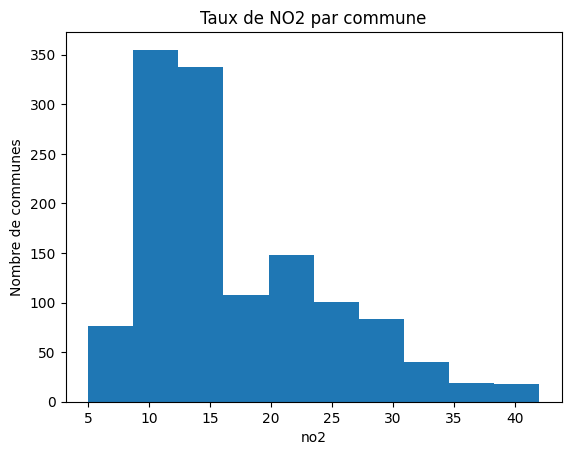

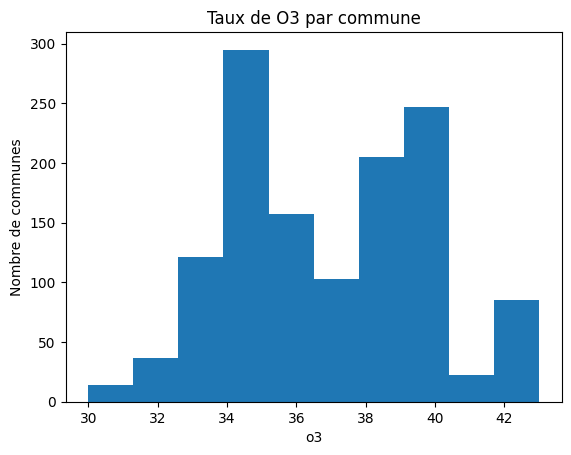

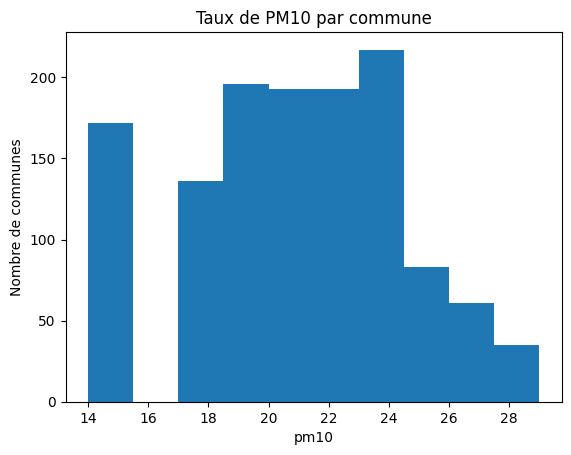

In [254]:
# NO2
plt.hist(communes_idf["no2"])
plt.xlabel("no2")
plt.ylabel("Nombre de communes")
plt.title("Taux de NO2 par commune")
plt.show()

# O3
plt.hist(communes_idf["o3"])
plt.xlabel("o3")
plt.ylabel("Nombre de communes")
plt.title("Taux de O3 par commune")
plt.show()

# PM10
plt.hist(communes_idf["pm10"])
plt.xlabel("pm10")
plt.ylabel("Nombre de communes")
plt.title("Taux de PM10 par commune")
plt.show()

In [290]:
## On crée des tertiles

# PM10
communes_idf_short["quantile_pm10"] = pd.qcut(
    communes_idf_short["pm10"],
    q=5,
    labels=[1, 2, 3, 4, 5]
)

# 03
communes_idf_short["quantile_o3"] = pd.qcut(
    communes_idf_short["o3"],
    q=5,
    labels=[1, 2, 3, 4, 5]
)

# N02
communes_idf_short["quantile_no2"] = pd.qcut(
    communes_idf_short["no2"],
    q=5,
    labels=[1, 2, 3, 4, 5]
)

In [291]:
communes_idf_short["quantile_pm10"] = pd.to_numeric(communes_idf_short["quantile_pm10"])
communes_idf_short["quantile_o3"] = pd.to_numeric(communes_idf_short["quantile_o3"])
communes_idf_short["quantile_no2"] = pd.to_numeric(communes_idf_short["quantile_no2"])

In [292]:
communes_idf_short["pollution_air"] = (
    communes_idf_short[["quantile_pm10", "quantile_o3", "quantile_no2"]]
    .mean(axis=1)
)

<Axes: >

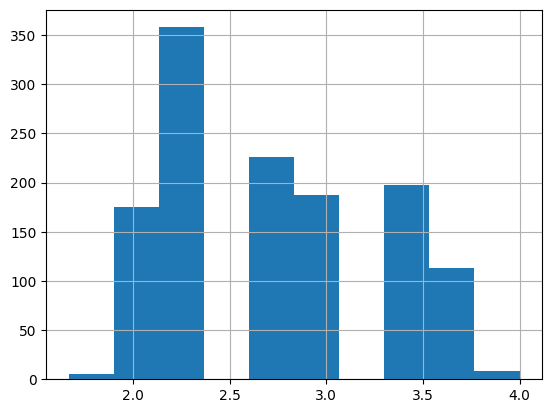

In [295]:
communes_idf_short["pollution_air"].hist()

In [297]:
communes_idf_short["pollution_air_forte"] = communes_idf_short["pollution_air"] > 3

In [301]:
(communes_idf_short["pollution_air_forte"] == True).sum()

np.int64(319)

(np.float64(1.3405956849999998),
 np.float64(3.6648696149999997),
 np.float64(48.06408132992269),
 np.float64(49.297495269618935))

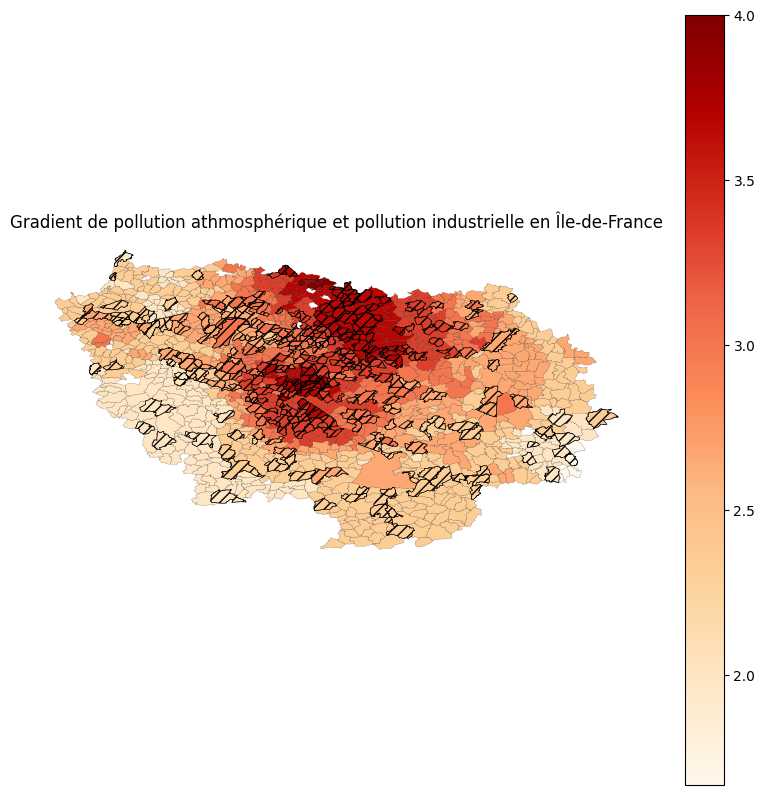

In [317]:
## Pollution air forte

fig, ax = plt.subplots(figsize=(10, 10))

communes_idf_short.plot(
    column="pollution_air",
    legend=True,
    cmap="OrRd",  # rouge / orange
    ax=ax,
    edgecolor="black",
    linewidth=0.1
)

communes_idf_short[communes_idf_short["Polluee"]].plot(
    facecolor="none",    # pas de remplissage
    hatch="///",         # motif de hachure
    linewidth=0.5,
    ax=ax
)

ax.set_title("Gradient de pollution athmosphérique et pollution industrielle en Île-de-France")
ax.axis("off")


In [316]:
communes_idf_short["Polluee"].corr(communes_idf_short["pollution_air"])

np.float64(0.2702172927004948)

(np.float64(1.3405956849999998),
 np.float64(3.6648696149999997),
 np.float64(48.06408132992269),
 np.float64(49.297495269618935))

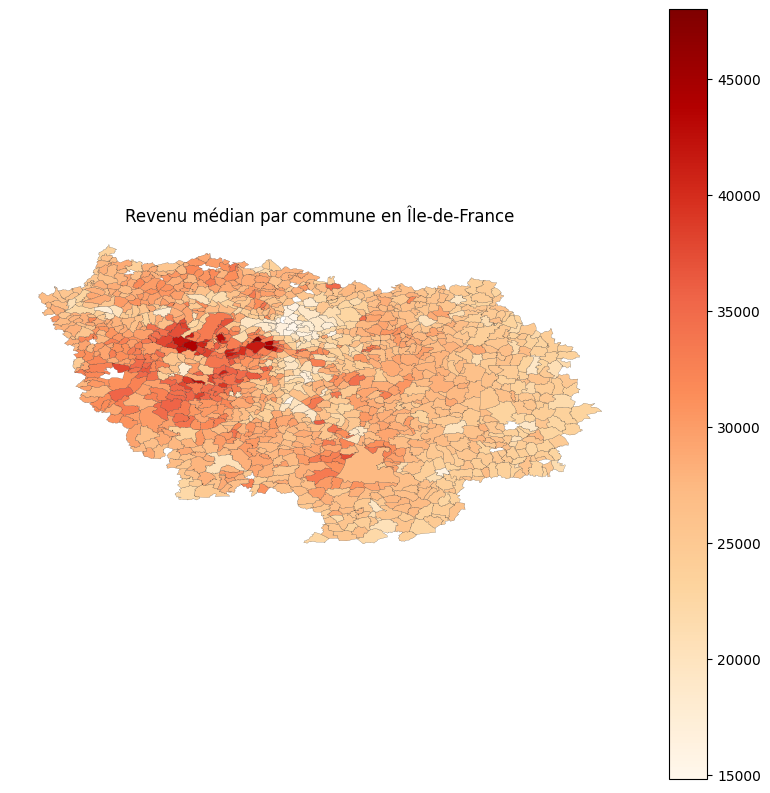

In [304]:
# Revenu médian

communes_idf_short["revenu_median_2021"] = communes_idf_short["revenu_median_2021"].astype(int)

fig, ax = plt.subplots(figsize=(10, 10))
communes_idf_short.plot(
    column="revenu_median_2021",
    legend=True,
    cmap="OrRd",  # rouge / orange
    ax=ax,
    edgecolor="black",
    linewidth=0.1
)

ax.set_title("Revenu médian par commune en Île-de-France")
ax.axis("off")

In [ ]:
##############################################
######### PARTIE 5 : MODELISATION ############
##############################################

In [41]:
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [ ]:
### PARAGRAPHE 1 : régressions de la qualité de l'air (pm10, o3, no2) sur des variables démographiques et spatiales

In [ ]:
## On régresse PM10 sur plein de variables

# Variable dépendante
y_pm10 = communes_idf_short['pm10']

# Variables explicatives
X_dem = communes_idf_short[['surf_ha', 'MED21', 'densite', 'Polluee', "P22_POP", "C22_POP15P", "C22_POP15P_STAT_GSEC11_21", "C22_POP15P_STAT_GSEC12_22",
"C22_POP15P_STAT_GSEC13_23", "C22_POP15P_STAT_GSEC14_24", "C22_POP15P_STAT_GSEC15_25", "C22_POP15P_STAT_GSEC16_26", "C22_POP15P_STAT_GSEC32",
"C22_POP15P_STAT_GSEC40", "P16_POP", "P11_POP", "P22_LOG", "ETBE23", "ENCTOT24", "ENCBE24", "HT25", "BPE_2024_B316",
"BPE_2024_C107", "BPE_2024_D265"]]

# Standardiser les colonnes continues
scaler = StandardScaler()
X_dem_scaled = pd.DataFrame(scaler.fit_transform(X_dem[['surf_ha', 'MED21', 'densite', "P22_POP", "C22_POP15P", "C22_POP15P_STAT_GSEC11_21", "C22_POP15P_STAT_GSEC12_22",
"C22_POP15P_STAT_GSEC13_23", "C22_POP15P_STAT_GSEC14_24", "C22_POP15P_STAT_GSEC15_25", "C22_POP15P_STAT_GSEC16_26", "C22_POP15P_STAT_GSEC32",
"C22_POP15P_STAT_GSEC40", "P16_POP", "P11_POP", "P22_LOG", "ETBE23", "ENCTOT24", "ENCBE24", "HT25", "BPE_2024_B316",
"BPE_2024_C107", "BPE_2024_D265"]]),

                        columns=['surf_ha', 'MED21', 'densite', "P22_POP", "C22_POP15P", "C22_POP15P_STAT_GSEC11_21", "C22_POP15P_STAT_GSEC12_22",
"C22_POP15P_STAT_GSEC13_23", "C22_POP15P_STAT_GSEC14_24", "C22_POP15P_STAT_GSEC15_25", "C22_POP15P_STAT_GSEC16_26", "C22_POP15P_STAT_GSEC32",
"C22_POP15P_STAT_GSEC40", "P16_POP", "P11_POP", "P22_LOG", "ETBE23", "ENCTOT24", "ENCBE24", "HT25", "BPE_2024_B316",
"BPE_2024_C107", "BPE_2024_D265"],
                        index=X_dem.index)

# On ajoute la variable binaire sans standardisation
X_dem_scaled['Polluee'] = X_dem['Polluee'].astype(int)

# On ajoute l'intercept
X_dem_const = sm.add_constant(X_dem_scaled)

# Construction et ajustement du modèle
model_pm10_dem_std = sm.OLS(y_pm10, X_dem_const).fit()

# Résumé complet
print(model_pm10_dem_std.summary())

                            OLS Regression Results                            
Dep. Variable:                   pm10   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     7.797
Date:                Tue, 16 Dec 2025   Prob (F-statistic):           3.37e-24
Time:                        14:11:53   Log-Likelihood:                -3373.5
No. Observations:                1270   AIC:                             6795.
Df Residuals:                    1246   BIC:                             6918.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [73]:
# On affiche les VIF (VIF > 5 : variable très corrélées aux autres variables du modèle)

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X_dem_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_dem_scaled.values, i) for i in range(X_dem_scaled.shape[1])]
print(vif_data)

                      feature          VIF
0                     surf_ha     1.255713
1                       MED21     1.721848
2                     densite     4.147476
3                     P22_POP  4204.374120
4                  C22_POP15P          inf
5   C22_POP15P_STAT_GSEC11_21          inf
6   C22_POP15P_STAT_GSEC12_22          inf
7   C22_POP15P_STAT_GSEC13_23          inf
8   C22_POP15P_STAT_GSEC14_24          inf
9   C22_POP15P_STAT_GSEC15_25          inf
10  C22_POP15P_STAT_GSEC16_26          inf
11     C22_POP15P_STAT_GSEC32          inf
12     C22_POP15P_STAT_GSEC40          inf
13                    P16_POP  2120.320895
14                    P11_POP  1127.828999
15                    P22_LOG   480.522301
16                     ETBE23    14.297223
17                   ENCTOT24    30.070655
18                    ENCBE24    29.843662
19                       HT25     5.823738
20              BPE_2024_B316     2.895152
21              BPE_2024_C107    21.573031
22         

/opt/python/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [74]:
## On écrit une fonction pour supprimer, de façon itérative, les variables avec un fort VIF (chatGPT : reprendre)

def reduce_vif(X, threshold=5):
    X = X.copy()
    
    while True:
        vif = pd.DataFrame({
            "feature": X.columns,
            "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        })
        
        max_vif = vif["VIF"].max()
        
        if max_vif <= threshold:
            break
        
        feature_to_drop = vif.loc[vif["VIF"].idxmax(), "feature"]
        print(f"Suppression de {feature_to_drop} (VIF = {max_vif:.2f})")
        
        X = X.drop(columns=[feature_to_drop])
    
    return X

In [75]:
# On applique la fonction : on supprime une par une les variables à fort VIF (ie très corrélées entre elles)
X_for_vif = X_dem_scaled.drop(columns=['Polluee'])
X_dem_reduced = reduce_vif(X_for_vif, threshold=5)
X_dem_reduced['Polluee'] = X_dem_scaled['Polluee']

/opt/python/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Suppression de C22_POP15P (VIF = inf)
Suppression de P22_POP (VIF = 4182.84)


Suppression de P16_POP (VIF = 1993.71)
Suppression de P11_POP (VIF = 486.37)
Suppression de P22_LOG (VIF = 245.41)
Suppression de C22_POP15P_STAT_GSEC15_25 (VIF = 147.99)
Suppression de C22_POP15P_STAT_GSEC14_24 (VIF = 64.99)
Suppression de C22_POP15P_STAT_GSEC32 (VIF = 48.40)
Suppression de C22_POP15P_STAT_GSEC40 (VIF = 46.58)
Suppression de ENCTOT24 (VIF = 28.18)
Suppression de C22_POP15P_STAT_GSEC12_22 (VIF = 18.79)
Suppression de BPE_2024_C107 (VIF = 14.68)
Suppression de ETBE23 (VIF = 11.16)
Suppression de C22_POP15P_STAT_GSEC13_23 (VIF = 8.01)


In [76]:
## On refait la régression avec moins de régresseurs

# On ajoute l'intercept
X_dem_reduced_const = sm.add_constant(X_dem_reduced)

# Construction et ajustement du modèle
model_pm10_dem_std_reduced = sm.OLS(y_pm10, X_dem_reduced_const).fit()

# Résumé complet
print(model_pm10_dem_std_reduced.summary())      

### REMARQUE : on a diminué les AIC et BIC mais le R^2 est toujours faible. On va faire mieux avec l'O3 et surtout le NO2.

                            OLS Regression Results                            
Dep. Variable:                   pm10   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     13.83
Date:                Tue, 16 Dec 2025   Prob (F-statistic):           2.21e-23
Time:                        14:12:06   Log-Likelihood:                -3392.7
No. Observations:                1270   AIC:                             6807.
Df Residuals:                    1259   BIC:                             6864.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [ ]:
#### Régression du o3 sur les variables "non spatiales"

# Variable dépendante
y_o3 = communes_idf_short['o3']

# Construction et ajustement du modèle
model_o3_dem_std = sm.OLS(y_o3, X_dem_const).fit()

# Résumé complet
print(model_o3_dem_std.summary())

### REMARQUE : le R^2 est légèrement meilleur (0.164) mais pareil pour les variables (à part densité, revenu médian et surface un peu)

                            OLS Regression Results                            
Dep. Variable:                     o3   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     14.00
Date:                Tue, 16 Dec 2025   Prob (F-statistic):           8.29e-48
Time:                        14:12:09   Log-Likelihood:                -3029.1
No. Observations:                1270   AIC:                             6106.
Df Residuals:                    1246   BIC:                             6230.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [78]:
## Pareil sur le modèle réduit

# Construction et ajustement du modèle
model_o3_dem_std_reduced = sm.OLS(y_o3, X_dem_reduced_const).fit()

# Résumé complet
print(model_o3_dem_std_reduced.summary())      

                            OLS Regression Results                            
Dep. Variable:                     o3   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     25.52
Date:                Tue, 16 Dec 2025   Prob (F-statistic):           1.93e-44
Time:                        14:12:13   Log-Likelihood:                -3057.9
No. Observations:                1270   AIC:                             6138.
Df Residuals:                    1259   BIC:                             6194.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [79]:
#### Régression du no2 sur les variables "non spatiales"

# Variable dépendante
y_no2 = communes_idf_short['no2']

# Construction et ajustement du modèle
model_no2_dem_std = sm.OLS(y_no2, X_dem_const).fit()

# Résumé complet
print(model_no2_dem_std.summary())

### REMARQUE : le R^2 est nettement meilleur (0.369) et quelques variables ont un rôle notable (densité, polluee, popuation, revenu médian)

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     49.35
Date:                Tue, 16 Dec 2025   Prob (F-statistic):          5.22e-157
Time:                        14:12:20   Log-Likelihood:                -3941.2
No. Observations:                1270   AIC:                             7930.
Df Residuals:                    1246   BIC:                             8054.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [80]:
#### Pareil sur le modèle réduit

# Construction et ajustement du modèle
model_no2_dem_std = sm.OLS(y_no2, X_dem_reduced_const).fit()

# Résumé complet
print(model_no2_dem_std.summary())

### REMARQUE : le R^2 baisse un peu (0.424)

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     92.73
Date:                Tue, 16 Dec 2025   Prob (F-statistic):          2.84e-143
Time:                        14:12:23   Log-Likelihood:                -4002.0
No. Observations:                1270   AIC:                             8026.
Df Residuals:                    1259   BIC:                             8083.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [ ]:
#### On réduit de pas à pas le vecteur explicatif en supprimant les variables non significatives (pour diminuer les AIC et BIC)

In [81]:
# On supprime ENCEBE24 (créations d'entreprises)
X_dem_reduced_const2 = X_dem_reduced_const.drop(columns=['ENCBE24'])  
model_no2_dem_std2 = sm.OLS(y_no2, X_dem_reduced_const2).fit()
print(model_no2_dem_std2.summary())

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     102.9
Date:                Tue, 16 Dec 2025   Prob (F-statistic):          4.52e-144
Time:                        14:12:42   Log-Likelihood:                -4002.5
No. Observations:                1270   AIC:                             8025.
Df Residuals:                    1260   BIC:                             8076.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [82]:
# On supprime HT25 (hôtels)
X_dem_reduced_const3 = X_dem_reduced_const2.drop(columns=['HT25'])  
model_no2_dem_std3 = sm.OLS(y_no2, X_dem_reduced_const3).fit()
print(model_no2_dem_std3.summary())

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     115.8
Date:                Tue, 16 Dec 2025   Prob (F-statistic):          4.85e-145
Time:                        14:12:53   Log-Likelihood:                -4002.7
No. Observations:                1270   AIC:                             8023.
Df Residuals:                    1261   BIC:                             8070.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [83]:
# On supprime Polluee (industries polluantes présentes)
X_dem_reduced_const4 = X_dem_reduced_const3.drop(columns=['Polluee'])  
model_no2_dem_std4 = sm.OLS(y_no2, X_dem_reduced_const4).fit()
print(model_no2_dem_std4.summary())

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     132.4
Date:                Tue, 16 Dec 2025   Prob (F-statistic):          4.38e-146
Time:                        14:12:55   Log-Likelihood:                -4002.7
No. Observations:                1270   AIC:                             8021.
Df Residuals:                    1262   BIC:                             8063.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [84]:
# On supprime MED21 (revenu médian)
X_dem_reduced_const5 = X_dem_reduced_const4.drop(columns=['MED21'])  
model_no2_dem_std5 = sm.OLS(y_no2, X_dem_reduced_const5).fit()
print(model_no2_dem_std5.summary())

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     154.3
Date:                Tue, 16 Dec 2025   Prob (F-statistic):          5.74e-147
Time:                        14:12:58   Log-Likelihood:                -4003.3
No. Observations:                1270   AIC:                             8021.
Df Residuals:                    1263   BIC:                             8057.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [85]:
### On ajoute à la régression les coordonnées géographiques pour voir si cela annule tout le reste

# On crée le df démographique et spatial
X_dem_spatial = X_dem_reduced_const5
X_dem_spatial[["x", "y"]] = communes_idf_short[["x", "y"]]

# on standardise
scaler = StandardScaler()
X_dem_spatial[["x", "y"]] = scaler.fit_transform(X_dem_spatial[["x", "y"]])

# On construit le modèle
model_no2_dem_spatial = sm.OLS(y_no2, X_dem_spatial).fit()
print(model_no2_dem_spatial.summary())

### REMARQUE : au total, x et y augmentent nettement le R^2 mais n'écrasent pas le reste.

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     200.1
Date:                Tue, 16 Dec 2025   Prob (F-statistic):          2.93e-218
Time:                        14:13:01   Log-Likelihood:                -3832.0
No. Observations:                1270   AIC:                             7682.
Df Residuals:                    1261   BIC:                             7728.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [86]:
### On ajoute l'effet croisé x*y

# Nouvelle variable
X_dem_spatial['densite_surf'] = X_dem_spatial['densite'] * X_dem_spatial['surf_ha']

# On construit le modèle
model_no2_dem_spatial2 = sm.OLS(y_no2, X_dem_spatial).fit()
print(model_no2_dem_spatial2.summary())

### REMARQUE : l'effet croisé semble fort et augmente un peu le R^2 (grandes villes et denses = les plus polluées)

                            OLS Regression Results                            
Dep. Variable:                    no2   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     181.9
Date:                Tue, 16 Dec 2025   Prob (F-statistic):          1.13e-220
Time:                        14:13:05   Log-Likelihood:                -3823.7
No. Observations:                1270   AIC:                             7667.
Df Residuals:                    1260   BIC:                             7719.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

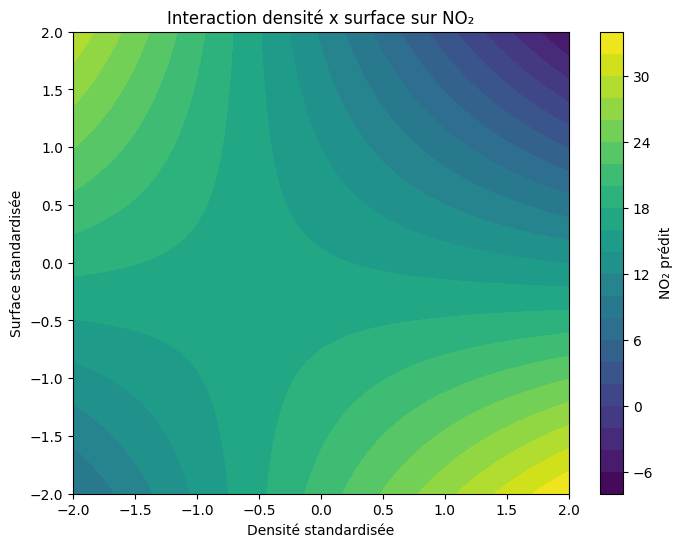

In [87]:
#### On visualise l'effet croisé surface / densité

# On récupère les coefs de la dernière régression
coef = model_no2_dem_spatial2.params

# On crée des séries de 50 valeurs pour discrétiser nos valeurs de densité et de surface (entre -2 et 2 écarts-types)
dens_vals = np.linspace(-2, 2, 50)
surf_vals = np.linspace(-2, 2, 50)

# On récupère toutes les combinaisons possibles, dans une matrice 2D, entre surface et densité
D, S = np.meshgrid(dens_vals, surf_vals)

# On prédit NO2 à partir des coefs pour chaque ligne
NO2_pred = (
    coef["const"] +
    coef["densite"] * D +
    coef["surf_ha"] * S +
    coef["densite_surf"] * D * S
)

# On représente les effets croisés
plt.figure(figsize=(8,6))
cp = plt.contourf(D, S, NO2_pred, levels=20, cmap='viridis')
plt.colorbar(cp, label='NO₂ prédit')
plt.xlabel('Densité standardisée')
plt.ylabel('Surface standardisée')
plt.title('Interaction densité x surface sur NO₂')
plt.show()

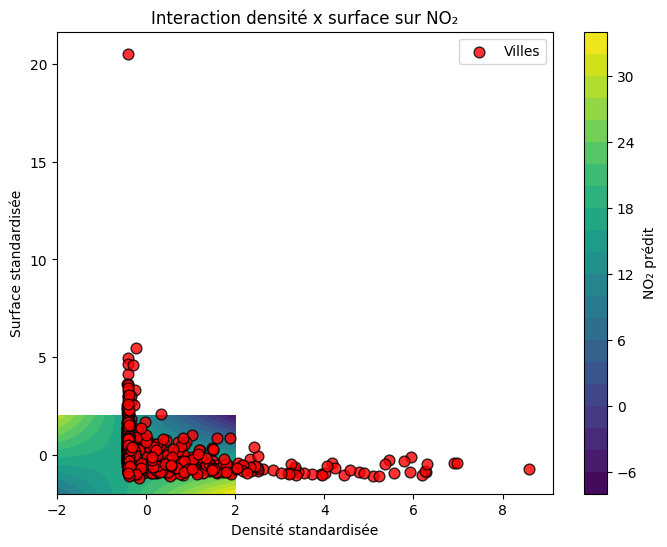

In [ ]:
densite = X_dem_spatial["densite"]
surf_ha = X_dem_spatial["surf_ha"]

# On récupère les coefs de la dernière régression
coef = model_no2_dem_spatial2.params

# On crée des séries de 50 valeurs pour discrétiser nos valeurs de densité et de surface (entre -2 et 2 écarts-types)
dens_vals = np.linspace(-2, 2, 50)
surf_vals = np.linspace(-2, 2, 50)

# On récupère toutes les combinaisons possibles, dans une matrice 2D, entre surface et densité
D, S = np.meshgrid(dens_vals, surf_vals)

# On prédit NO2 à partir des coefs pour chaque ligne
NO2_pred = (
    coef["const"] +
    coef["densite"] * D +
    coef["surf_ha"] * S +
    coef["densite_surf"] * D * S
)

plt.figure(figsize=(8,6))

cp = plt.contourf(D, S, NO2_pred, levels=20, cmap='viridis')
plt.colorbar(cp, label='NO₂ prédit')

# Ajout des villes
plt.scatter(
    densite,
    surf_ha,
    color='red',
    edgecolor='black',
    s=60,
    alpha=0.8,
    label='Villes'
)

plt.xlabel('Densité standardisée')
plt.ylabel('Surface standardisée')
plt.title('Interaction densité x surface sur NO₂')
plt.legend()
plt.show()

(array([18.1635021 ,  8.42681708,  3.97326608,  2.35776229,  1.44085473,
         1.44085473,  1.00423209,  0.61127171,  0.82958303,  0.48028491,
         0.65493397,  0.61127171,  0.56760944,  0.34929812,  0.21831132,
         0.39296038,  0.34929812,  0.43662265,  0.34929812,  0.30563585,
         0.17464906,  0.13098679,  0.21831132,  0.43662265,  0.17464906,
         0.17464906,  0.13098679,  0.13098679,  0.04366226,  0.26197359,
         0.08732453,  0.21831132,  0.21831132,  0.21831132,  0.04366226,
         0.39296038,  0.17464906,  0.21831132,  0.17464906,  0.08732453,
         0.30563585,  0.26197359,  0.08732453,  0.08732453,  0.04366226,
         0.26197359,  0.08732453,  0.21831132,  0.13098679,  0.08732453,
         0.13098679,  0.08732453,  0.17464906,  0.04366226,  0.08732453,
         0.08732453,  0.08732453,  0.08732453,  0.04366226,  0.04366226,
         0.        ,  0.17464906,  0.08732453,  0.17464906,  0.04366226,
         0.08732453,  0.08732453,  0.04366226,  0.0

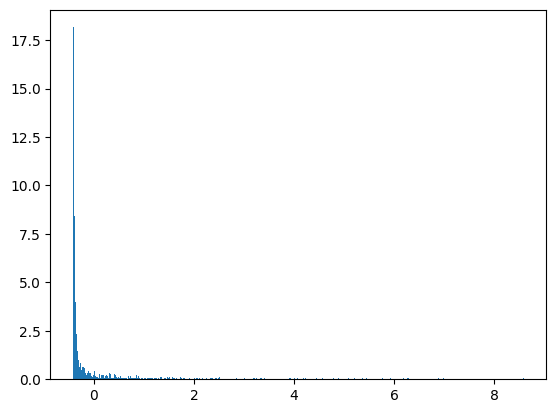

In [110]:
plt.hist(densite, bins=500, density=True)